In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import os
import os.path
import sys
import tensorflow as tf
import math
from data_loader import DataLoader
from my_constants import Constants
from emotion_classifier import EmotionClassifier
import numpy as np
import scipy
import pandas as pd

np.random.seed(666)

# Logistics

In [2]:
model_name = 'FC'
batch_size = 90
seed = 666
filename = '/mas/u/asma_gh/uncnet/datasets/FER+/all.csv'
max_nrof_epochs=100000
hidden_layer_size=[128, 128]
keep_probability=0.8
weight_decay=0.0
n_epistemic = 100
n_aleatoric = 100

logs_base_dir = '/mas/u/asma_gh/uncnet/epoch_logs_model'
embedding_model = 'CASIA_WebFace_Inception_ResNet_v1'
embedding_layer = 'Mixed_7a'
learning_rate = 0.0001

# Load data

In [3]:
data_loader = DataLoader(filename, import_embedding=True, embedding_model=embedding_model,
                                      embedding_layer=embedding_layer, seed=seed)

Converting row 0 of dataframe to numpy array.
Converting row 100 of dataframe to numpy array.
Converting row 200 of dataframe to numpy array.
Converting row 300 of dataframe to numpy array.
Converting row 400 of dataframe to numpy array.
Converting row 500 of dataframe to numpy array.
Converting row 600 of dataframe to numpy array.
Converting row 700 of dataframe to numpy array.
Converting row 800 of dataframe to numpy array.
Converting row 900 of dataframe to numpy array.
Converting row 1000 of dataframe to numpy array.
Converting row 1100 of dataframe to numpy array.
Converting row 1200 of dataframe to numpy array.
Converting row 1300 of dataframe to numpy array.
Converting row 1400 of dataframe to numpy array.
Converting row 1500 of dataframe to numpy array.
Converting row 1600 of dataframe to numpy array.
Converting row 1700 of dataframe to numpy array.
Converting row 1800 of dataframe to numpy array.
Converting row 1900 of dataframe to numpy array.
Converting row 2000 of dataframe

Converting row 14600 of dataframe to numpy array.
Converting row 14700 of dataframe to numpy array.
Converting row 14800 of dataframe to numpy array.
Converting row 14900 of dataframe to numpy array.
Converting row 15000 of dataframe to numpy array.
Converting row 15100 of dataframe to numpy array.
Converting row 15200 of dataframe to numpy array.
Converting row 15300 of dataframe to numpy array.
Converting row 15400 of dataframe to numpy array.
Converting row 15500 of dataframe to numpy array.
Converting row 15600 of dataframe to numpy array.
Converting row 15700 of dataframe to numpy array.
Converting row 15800 of dataframe to numpy array.
Converting row 15900 of dataframe to numpy array.
Converting row 16000 of dataframe to numpy array.
Converting row 16100 of dataframe to numpy array.
Converting row 16200 of dataframe to numpy array.
Converting row 16300 of dataframe to numpy array.
Converting row 16400 of dataframe to numpy array.
Converting row 16500 of dataframe to numpy array.


Converting row 29000 of dataframe to numpy array.
Converting row 29100 of dataframe to numpy array.
Converting row 29200 of dataframe to numpy array.
Converting row 29300 of dataframe to numpy array.
Converting row 29400 of dataframe to numpy array.
Converting row 29500 of dataframe to numpy array.
Converting row 29600 of dataframe to numpy array.
Converting row 29700 of dataframe to numpy array.
Converting row 29800 of dataframe to numpy array.
Converting row 29900 of dataframe to numpy array.
Converting row 30000 of dataframe to numpy array.
Converting row 30100 of dataframe to numpy array.
Converting row 30200 of dataframe to numpy array.
Converting row 30300 of dataframe to numpy array.
Converting row 30400 of dataframe to numpy array.
Converting row 30500 of dataframe to numpy array.
Converting row 30600 of dataframe to numpy array.
Converting row 30700 of dataframe to numpy array.
Converting row 30800 of dataframe to numpy array.
Converting row 30900 of dataframe to numpy array.


In [4]:
test_labels, test_embeddings = data_loader.get_test_batch()
valid_labels, valid_embeddings = data_loader.get_valid_batch()

In [5]:
def load_model_dir(best_checkpoints, uncertainty_type):
    epoch_num = best_checkpoints[uncertainty_type]
    model_filename = f'{model_name}_{epoch_num}.ckpt-{epoch_num}'
    root_dir = f'{logs_base_dir}/{embedding_model}/{embedding_layer}/{str(learning_rate)}/{uncertainty_type}'
    
    model_dir = None
    for sub_dir in os.listdir(root_dir):
        if sub_dir.startswith('.'):
            continue
        model_dir = os.path.join(os.path.join(root_dir, sub_dir), model_filename)
    if not model_dir:
        print ('Error! Did not find model.')
        return None
    return model_dir

# Load model

In [6]:
def get_performance_on_data(best_checkpoints, uncertainty_type, x, y):
    model_dir = load_model_dir(best_checkpoints, uncertainty_type)
    tf.reset_default_graph()
    with tf.Session() as sess:    
        saver = tf.train.import_meta_graph(f'{model_dir}.meta')
        saver.restore(sess, model_dir)
        
        tf_loss = tf.get_default_graph().get_tensor_by_name("loss:0")
        tf_acc = tf.get_default_graph().get_tensor_by_name("acc:0")
        tf_x = tf.get_default_graph().get_tensor_by_name("x:0")
        tf_y = tf.get_default_graph().get_tensor_by_name("y:0")
        tf_dropout_prob = tf.get_default_graph().get_tensor_by_name("dropout_prob:0")
        
        tf_logits = tf.get_default_graph().get_tensor_by_name("logits:0")
        if uncertainty_type == 'aleatoric' or uncertainty_type == 'both':
            tf_logits_mean = tf.get_default_graph().get_tensor_by_name("logits_mean:0")
            tf_logits_var = tf.get_default_graph().get_tensor_by_name("logits_var:0")

        aleatoric_u = None
        aleatoric_p_u = None
        
        epistemic_u = None
        epistemic_p_u = None
        
        def mc_aleatoric_sampling(mean_logits, aleatoric_u):
            mc_logits = []
            mc_class_probabilities = []
            for i in range(n_aleatoric):
                sampled_noise = np.random.normal(loc=np.zeros_like(mean_logits), scale=np.transpose([np.sqrt(aleatoric_u)]*9)) # num_classes
                distorted_logits = mean_logits + sampled_noise
                mc_logits.append(distorted_logits)
                mc_class_probabilities.append(scipy.special.softmax(distorted_logits))
            aleatoric_p_u = np.var(mc_class_probabilities, axis=(0,2))
            return aleatoric_p_u

        def mc_epistemic_sampling():
            mc_logits = []
            mc_class_probabilities = []
            mc_losses = []
            for i in range(n_epistemic):
                loss, logits = sess.run([tf_loss, tf_logits], feed_dict={
                    tf_x: x, tf_y: y, tf_dropout_prob: keep_probability})
                mc_logits.append(logits)
                mc_class_probabilities.append(scipy.special.softmax(logits))
                mc_losses.append(loss)
            mean_logits = np.mean(mc_logits, axis=0)
            score = calc_acc(mean_logits, y)
            epistemic_u = np.var(mc_logits, axis=(0,2))
            epistemic_p_u = np.var(mc_class_probabilities, axis=(0,2))
            return mc_logits, mc_class_probabilities, np.mean(mc_losses), score, epistemic_u, epistemic_p_u

        def calc_acc(logits, y):
            class_probabilities = scipy.special.softmax(logits)
            predictions = np.argmax(class_probabilities, axis=1)
            target = np.argmax(y, axis=1)
            acc = np.mean(np.equal(target, predictions))
            return acc

        """Returns the model's performance on input data X and targets Y."""
        if uncertainty_type == 'none':
            loss, score, logits = sess.run([tf_loss, tf_acc, tf_logits], feed_dict={
                tf_x: x, tf_y: y, tf_dropout_prob: 1.0})
            class_probabilities = scipy.special.softmax(logits)
        elif uncertainty_type == 'aleatoric':
            loss, score, logits, aleatoric_u = sess.run([tf_loss, tf_acc, tf_logits_mean, tf_logits_var], feed_dict={
                tf_x: x, tf_y: y, tf_dropout_prob: 1.0})
            aleatoric_p_u = mc_aleatoric_sampling(logits, aleatoric_u)
            class_probabilities = scipy.special.softmax(logits)
        elif uncertainty_type == 'epistemic':
            mc_logits, mc_class_probabilities, loss, score, epistemic_u, epistemic_p_u = mc_epistemic_sampling()
            class_probabilities = np.mean(mc_class_probabilities, axis=0)
        elif uncertainty_type == 'both':
            logits, aleatoric_u = sess.run([tf_logits_mean, tf_logits_var], feed_dict={
                tf_x: x, tf_y: y, tf_dropout_prob: 1.0})
            aleatoric_p_u = mc_aleatoric_sampling(logits, aleatoric_u)
            mc_logits, mc_class_probabilities, loss, score, epistemic_u, epistemic_p_u = mc_epistemic_sampling()
            class_probabilities = np.mean(mc_class_probabilities, axis=0)

        return loss, score, class_probabilities, aleatoric_u, aleatoric_p_u, epistemic_u, epistemic_p_u

# Preparing for answering research questions
Loading best checkpoints per uncertainty type

In [7]:
# BEST_CHECKPOINTS = {'none': 1068, 'aleatoric':1012 ,'epistemic': 319 , 'both':53} # TODO only none is done
# BEST_CHECKPOINTS = {'none': 403, 'aleatoric':353 ,'epistemic': 406 , 'both':192}
# BEST_CHECKPOINTS = {'none': 403, 'aleatoric':428 ,'epistemic': 406 , 'both':192}
BEST_CHECKPOINTS = {'none': 403, 'aleatoric':428 ,'epistemic': 474 , 'both':530}

# using logits (_u) or probabilities (_p_u) uncertainties?
unc_postfix = '_u' #'_p_u'

# Q1: Does modeling uncertainty improve accuracy?

Observation: The results are very similar on the hold-out test set. Aleatoric uncnet is slightly better than baseline.

#### Sanity check
Do the validation results map the tensorboard?

In [8]:
unc_types = ['none', 'aleatoric', 'epistemic', 'both']
# Get validation results
print ('Validation set:')
for unc in unc_types:
    print (f'\nModeling {unc} uncertainties...')
    loss, score, class_probabilities, aleatoric_u, aleatoric_p_u, epistemic_u, epistemic_p_u = get_performance_on_data(BEST_CHECKPOINTS, unc,
                                                                    valid_embeddings, valid_labels)
    print(f'loss: {loss:.5f}, score: {score:.5f}, aleatoric_u: {aleatoric_u}, aleatoric_p_u: {aleatoric_p_u}, epistemic_u: {epistemic_u}, epistemic_p_u: {epistemic_p_u}')
    

Validation set:

Modeling none uncertainties...
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/none/2019_04_22_10_36_21/FC_403.ckpt-403
loss: 1.53035, score: 0.54912, aleatoric_u: None, aleatoric_p_u: None, epistemic_u: None, epistemic_p_u: None

Modeling aleatoric uncertainties...
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/aleatoric/2019_04_22_10_36_21/FC_428.ckpt-428
loss: 1.52792, score: 0.54268, aleatoric_u: [3.16400750e-09 1.14716656e-07 1.13852954e-08 ... 1.83565987e-07
 1.58265095e-10 2.04981626e-12], aleatoric_p_u: [6.23337433e-10 3.98934106e-10 7.36141951e-10 ... 2.61254705e-10
 1.38161541e-09 1.73269304e-09], epistemic_u: None, epistemic_p_u: None

Modeling epistemic uncertainties...
INFO:tensorflow:Restoring parameters f

#### How about the unseen test set?

In [9]:
unc_types = ['none', 'aleatoric', 'epistemic', 'both']

# Get test results
print ('Test set:')
for unc in unc_types:
    print (f'\nModeling {unc} uncertainties...')
    loss, score, class_probabilities, aleatoric_u, aleatoric_p_u, epistemic_u, epistemic_p_u = get_performance_on_data(BEST_CHECKPOINTS, unc,
                                                                    test_embeddings, test_labels)
    print(f'loss: {loss:.5f}, score: {score:.5f}, aleatoric_u: {aleatoric_u}, aleatoric_p_u: {aleatoric_p_u}, epistemic_u: {epistemic_u}, epistemic_p_u: {epistemic_p_u}')
    

Test set:

Modeling none uncertainties...
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/none/2019_04_22_10_36_21/FC_403.ckpt-403
loss: 1.49306, score: 0.54848, aleatoric_u: None, aleatoric_p_u: None, epistemic_u: None, epistemic_p_u: None

Modeling aleatoric uncertainties...
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/aleatoric/2019_04_22_10_36_21/FC_428.ckpt-428
loss: 1.49132, score: 0.55351, aleatoric_u: [3.7455885e-07 6.2037685e-08 5.3684352e-07 ... 6.6229440e-17 9.6051667e-10
 5.1468400e-13], aleatoric_p_u: [2.42855046e-10 4.51856484e-10 2.67517892e-10 ... 3.85412885e-09
 7.78384400e-10 2.05101974e-09], epistemic_u: None, epistemic_p_u: None

Modeling epistemic uncertainties...
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/episte

# Q2: Does excluding the points with high uncertainty, improve accuracy?

Observation: 

Sorting by aleatoric, yes, the performance of baseline and UncNet will both improve similarly.

Ironically, sorting by epistemic, the performance will be reduced.

In [10]:
dataset = pd.read_csv(filename)
test = dataset[dataset['dataset'] == 'PublicTest'].reset_index(drop=True)
test['original_ind'] = test.index

In [11]:
loss, score, class_probabilities, aleatoric_u, aleatoric_p_u, epistemic_u, epistemic_p_u = get_performance_on_data(
    BEST_CHECKPOINTS, 'both', test_embeddings, test_labels)

INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/both/2019_04_22_10_36_21/FC_530.ckpt-530


In [12]:
test['aleatoric_u'] = aleatoric_u*1000000.0
test['epistemic_u'] = epistemic_u
test['aleatoric_p_u'] = aleatoric_p_u*1000000.0
test['epistemic_p_u'] = epistemic_p_u*1000000.0

In [13]:
def find_unc_samples(test, uncertainty_type, percentage=0.75, sort_ascending=True):
    '''
    Find samples that are in the [percentage] quantile with 
    highest or lowest uncertainty values based on [sort_ascending]
    '''
    test = test.sort_values(by=f'{uncertainty_type}{unc_postfix}', ascending=sort_ascending)
    max_ind = int(percentage*len(test))
    sub_index = test.index[0:max_ind]
    return sub_index

for unc in ['aleatoric', 'epistemic']:
    print (f'Sorting based on uncertainty type: {unc}...')
    sub_indices = find_unc_samples(test, unc)
    sub_test_embeddings = test_embeddings[sub_indices]
    sub_test_labels = test_labels[sub_indices]
    for unc_type in ['none', 'both']:
        print(f'New performance metrics for {unc_type}:')
        loss, score, class_probabilities, aleatoric_u, aleatoric_p_u, epistemic_u, epistemic_p_u = get_performance_on_data(BEST_CHECKPOINTS, unc_type, sub_test_embeddings, sub_test_labels)
        print(f'loss: {loss:.5f}, score: {score:.5f}, aleatoric_u: {aleatoric_u}, aleatoric_p_u: {aleatoric_p_u}, epistemic_u: {epistemic_u}, epistemic_p_u: {epistemic_p_u}')
        

Sorting based on uncertainty type: aleatoric...
New performance metrics for none:
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/none/2019_04_22_10_36_21/FC_403.ckpt-403
loss: 1.38781, score: 0.60246, aleatoric_u: None, aleatoric_p_u: None, epistemic_u: None, epistemic_p_u: None
New performance metrics for both:
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/both/2019_04_22_10_36_21/FC_530.ckpt-530
loss: 1.45908, score: 0.60544, aleatoric_u: [1.0680939e-23 1.4571755e-21 1.8326243e-19 ... 4.3195932e-08 4.3203510e-08
 4.3338702e-08], aleatoric_p_u: [2.35753075e-08 2.52962474e-07 5.98175605e-07 ... 8.53022187e-10
 7.80293416e-10 6.97182144e-10], epistemic_u: [ 4.937665  10.835754   7.5141296 ...  1.1098187  1.2598332  1.0642012], epistemic_p_u: [4.0259174e-08 1.5892596e-05 5.0431477e-06 ... 7.0129375e-10 6.9135214e-10
 5.03

# Q3: Is there a relationship between inter-rater agreement and uncertainty?

Observation:

There is a significant positive correlation between aleatoric uncertainty and disagreement_p/entropy

There is a significant negative correlation between epistemic uncertainty and disagreement_p/entropy

<Figure size 360x360 with 0 Axes>

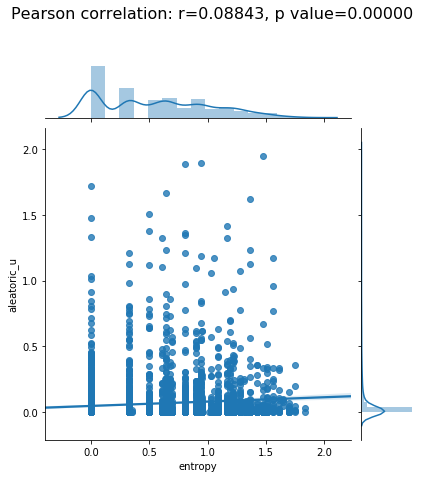

<Figure size 360x360 with 0 Axes>

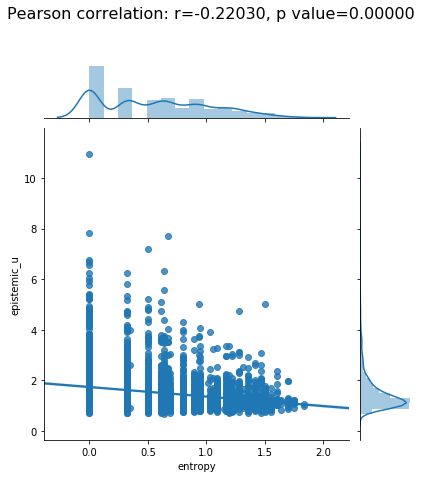

<Figure size 360x360 with 0 Axes>

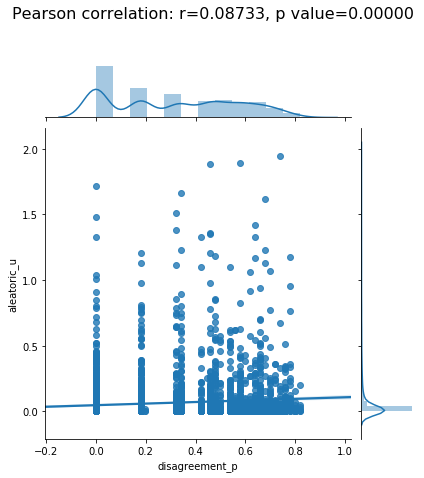

<Figure size 360x360 with 0 Axes>

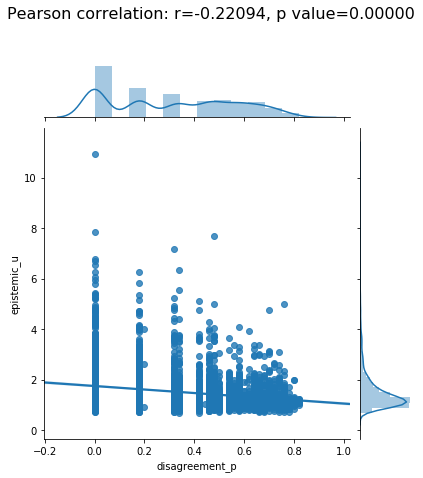

In [14]:
def comparison_plots(test, x, y):
    plt.figure(figsize=(5,5))
    g = sns.jointplot(test[x], test[y], kind="reg")
    r, p = scipy.stats.pearsonr(test[x], test[y])
    plt.suptitle(f'Pearson correlation: r={r:.5f}, p value={p:.5f}', size=16, y=1.1)
    plt.ylabel(y)
    plt.xlabel(x)
    
for x in ['entropy', 'disagreement_p']:
    comparison_plots(test, x, f'aleatoric{unc_postfix}')
    comparison_plots(test, x, f'epistemic{unc_postfix}')


# Q4: What do samples with high/low aleatoric/epistemic uncertainty look like?

Observations:

Samples with low aleatoric uncertainty have higher inter-annotator agreement, i.e. less spread in the annotations distribution. Inversely, high aleatoric uncertainty -> lower agreement

Uncertainty type: aleatoric
Uncertainty type: epistemic


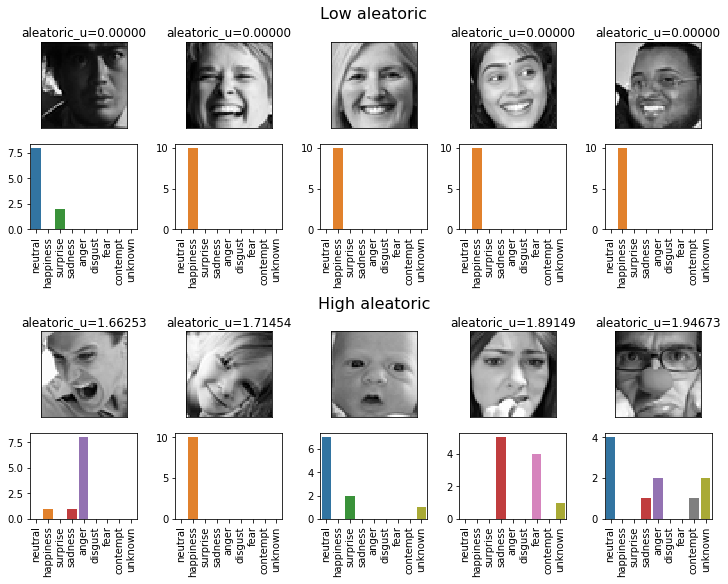

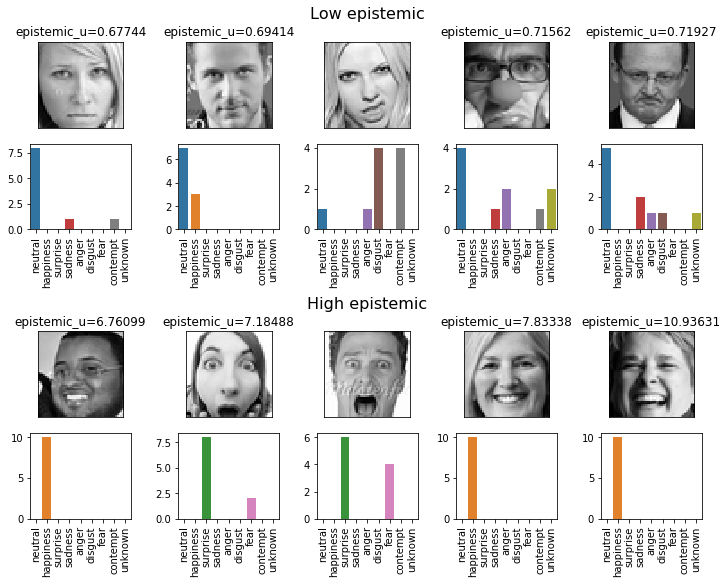

In [15]:
EMOTION_COLS = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt' ,'unknown']
def _plot_img_hist(inp, axes, ax_i, ax_j, ttl_col):
    img_ax = axes[ax_i, ax_j]
    hist_ax = axes[ax_i+1, ax_j]
    
    NEW_SHAPE = (48, 48)
    img_arr = np.array([int(i) for i in inp['pixels'].split(' ')])
    img_arr = np.reshape(img_arr, NEW_SHAPE)
    img_ax.set_title(f'{ttl_col}={inp[ttl_col]:.5f}')
    img_ax.imshow(img_arr, cmap='gray')
    img_ax.set_xticks([])
    img_ax.set_yticks([])
    
    sns.barplot(np.arange(len(EMOTION_COLS)), list(inp[EMOTION_COLS]), ax=hist_ax)
    hist_ax.set_xticklabels(EMOTION_COLS, rotation='vertical')


# Show n images with highest disagreement and n images with lowest disagreement probability
def show_extreme_cases(inp, n, ttl_col):
    f, axes = plt.subplots(4, n, figsize=(n*2, 8), constrained_layout=True)
    for i in range(n):
        _plot_img_hist(inp.iloc[i], axes, 0, i, f'{ttl_col}{unc_postfix}')
    axes[0, int(n/2)].set_title(f'Low {ttl_col}', size=16, y=1.2)
    
    for i in range(n):
        _plot_img_hist(inp.iloc[len(inp)-1-i], axes, 2, n-i-1, f'{ttl_col}{unc_postfix}')
    axes[2, int(n/2)].set_title(f'High {ttl_col}', size=16, y=1.2)

for unc in ['aleatoric', 'epistemic']:
    print (f'Uncertainty type: {unc}')
    sorted_test = test.sort_values(by=f'{unc}{unc_postfix}')
    show_extreme_cases(sorted_test, 5, unc)
    

# Q5: Maybe doesn't influence accuracy, but are the softmax outputs better caliberated?

Note that because of the way we formed the problem and used aggregate user ratings, traditional caliberation metrics such as Expected Calibration Error (ECE), Maximum Calibration Error (MCE), and reliability diagram may not be relevant. Here, we use distribution distance metrics between predicted and input probabilities.

Observations:

It is in the directions we want. But the differences are small.

jensen shannon distance of probabilites in uncnet codition used to be slightly lower. Now it is slightly higher :|

cosine similarity of probabilities with uncnet is slightly higher.

In [16]:
_, _, baseline_class_probabilities, _, _, _, _ = get_performance_on_data(
    BEST_CHECKPOINTS, 'none', test_embeddings, test_labels)

_, _, uncnet_class_probabilities, _, _, _, _ = get_performance_on_data(
    BEST_CHECKPOINTS, 'both', test_embeddings, test_labels)

INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/none/2019_04_22_10_36_21/FC_403.ckpt-403
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/both/2019_04_22_10_36_21/FC_530.ckpt-530


In [17]:
def print_distance_metrics(pred, true, ttl):
    print ('\n'+ttl)
    js_s = []
    s_sim_s =[]
    for i in range(len(pred)):
        js_s.append(scipy.spatial.distance.jensenshannon(pred[i], true[i]))
        s_sim_s.append(scipy.spatial.distance.cosine(pred[i], true[i]))
    print (f'Jensen shannon distance: mean={np.mean(js_s):.3f}, std={np.std(js_s):.3f}')
    print (f'Cosine similiraty: mean={np.mean(s_sim_s):.3f}, std={np.std(s_sim_s):.3f}')
#     return np.mean(js_s), np.std(js_s), np.mean(s_sim_s), np.std(s_sim_s)

print_distance_metrics(baseline_class_probabilities, test_labels, 'Baseline')
print_distance_metrics(uncnet_class_probabilities, test_labels, 'UncNet')


Baseline
Jensen shannon distance: mean=0.473, std=0.131
Cosine similiraty: mean=0.308, std=0.264

UncNet
Jensen shannon distance: mean=0.480, std=0.132
Cosine similiraty: mean=0.314, std=0.256


### More examples

Uncertainty type: aleatoric
Uncertainty type: epistemic


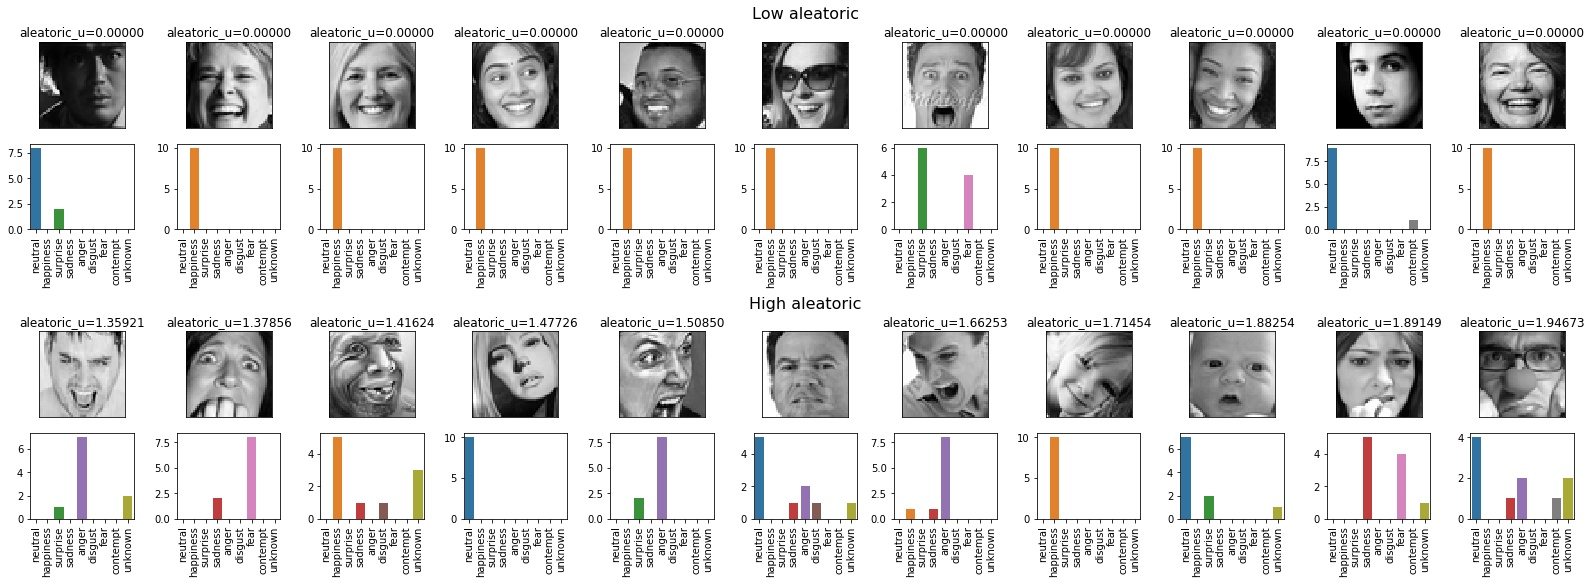

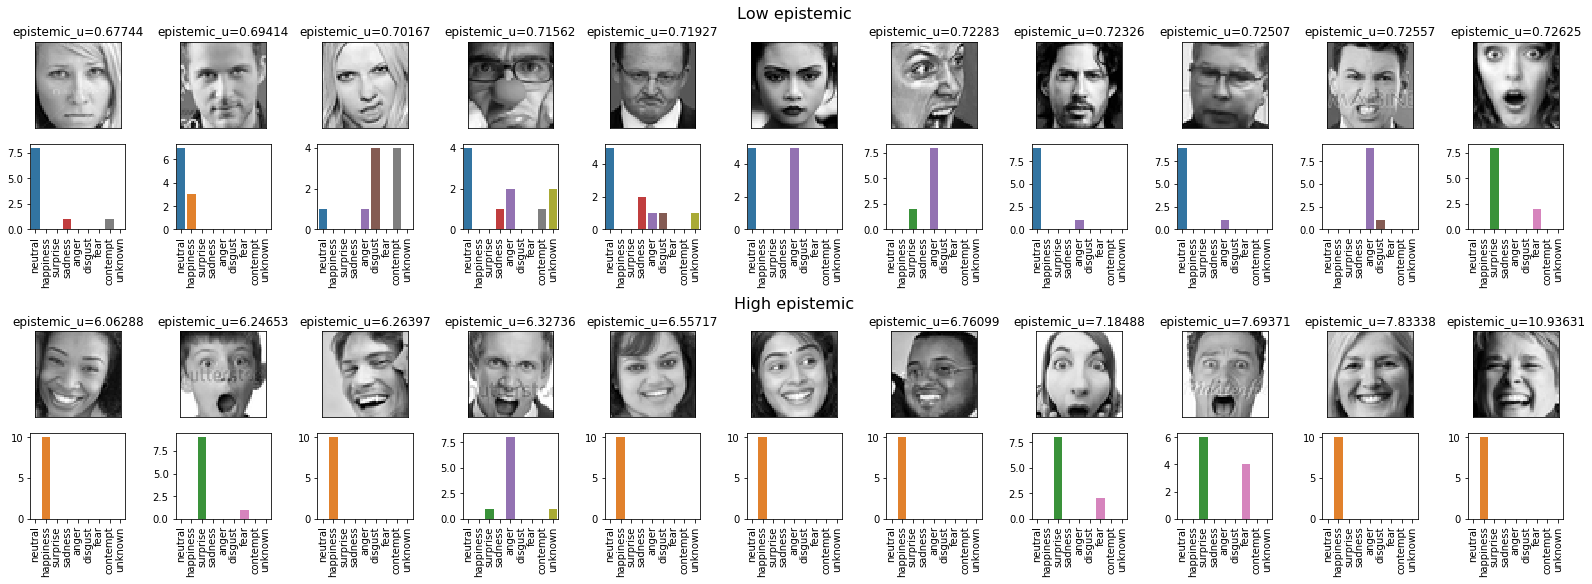

In [18]:
for unc in ['aleatoric', 'epistemic']:
    print (f'Uncertainty type: {unc}')
    sorted_test = test.sort_values(by=f'{unc}{unc_postfix}')
    show_extreme_cases(sorted_test, 11, unc)

# Debugging only

In [102]:
#WHAT??? {unc}_u and {unc}_p_u should have roughly the same ranking order. What's happening here?
test[['aleatoric_u', 'aleatoric_p_u', 'epistemic_u', 'epistemic_p_u']]

,aleatoric_u,aleatoric_p_u,epistemic_u,epistemic_p_u
0,0.676351,0.000432,0.936957,0.000347
1,0.057500,0.000678,1.322191,0.000808
2,0.524970,0.000492,0.988073,0.000460
3,0.178939,0.000792,1.036464,0.000663
4,0.000479,0.006083,2.067470,0.008716
5,0.000006,0.026216,2.740210,0.053564
6,0.064609,0.000992,1.181742,0.000859
7,0.004312,0.001018,1.412202,0.000988
8,0.001311,0.001765,1.622488,0.001906
9,0.363994,0.000588,0.917749,0.000517


# Legacy

In [ ]:
def get_performance_on_data(best_checkpoints, uncertainty_type, x, y):
    model_dir = load_model_dir(best_checkpoints, uncertainty_type)
    tf.reset_default_graph()
    with tf.Session() as sess:    
        saver = tf.train.import_meta_graph(f'{model_dir}.meta')
        saver.restore(sess, model_dir)
        
        tf_loss = tf.get_default_graph().get_tensor_by_name("loss:0")
        tf_acc = tf.get_default_graph().get_tensor_by_name("acc:0")
        tf_x = tf.get_default_graph().get_tensor_by_name("x:0")
        tf_y = tf.get_default_graph().get_tensor_by_name("y:0")
        tf_dropout_prob = tf.get_default_graph().get_tensor_by_name("dropout_prob:0")
        
        tf_logits = tf.get_default_graph().get_tensor_by_name("logits:0")
        if uncertainty_type == 'aleatoric' or uncertainty_type == 'both':
            tf_logits_mean = tf.get_default_graph().get_tensor_by_name("logits_mean:0")
            tf_logits_var = tf.get_default_graph().get_tensor_by_name("logits_var:0")

        aleatoric_u = None
        epistemic_u = None

        def mc_epistemic_sampling():
            mc_logits = []
            mc_losses = []
            for i in range(n_epistemic):
                loss, logits = sess.run([tf_loss, tf_logits], feed_dict={
                    tf_x: x, tf_y: y, tf_dropout_prob: keep_probability})
                mc_logits.append(logits)
                mc_losses.append(loss)
            mean_logits = np.mean(mc_logits, axis=0)
            score = calc_acc(mean_logits, y)
            epistemic_u = np.var(mc_logits, axis=(0,2))
            return mc_logits, np.mean(mc_losses), score, epistemic_u

        def calc_acc(logits, y):
            class_probabilities = scipy.special.softmax(logits)
            predictions = np.argmax(class_probabilities, axis=1)
            target = np.argmax(y, axis=1)
            acc = np.mean(np.equal(target, predictions))
            return acc

        """Returns the model's performance on input data X and targets Y."""
        if uncertainty_type == 'none':
            loss, score, logits = sess.run([tf_loss, tf_acc, tf_logits], feed_dict={
                tf_x: x, tf_y: y, tf_dropout_prob: 1.0})
        elif uncertainty_type == 'aleatoric':
            loss, score, logits, aleatoric_u = sess.run([tf_loss, tf_acc, tf_logits_mean, tf_logits_var], feed_dict={
                tf_x: x, tf_y: y, tf_dropout_prob: 1.0})
        elif uncertainty_type == 'epistemic':
            mc_logits, loss, score, epistemic_u = mc_epistemic_sampling()
        elif uncertainty_type == 'both':
            aleatoric_u = sess.run(tf_logits_var, feed_dict={
                tf_x: x, tf_y: y, tf_dropout_prob: 1.0})
            mc_logits, loss, score, epistemic_u = mc_epistemic_sampling()

        return loss, score, aleatoric_u, epistemic_u